In [76]:
import pandas as pd
import numpy as np

import scanpy as sc
import biolord

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_rel, ttest_ind
import itertools
import anndata
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests


In [35]:
warnings.simplefilter("ignore", UserWarning)

In [36]:
adata = sc.read_h5ad("/exports/archive/hg-funcgenom-research/Genelab_dataset/OSD-562/adata_raw.h5ad")

In [37]:
def convert_to_float(value):
    if 'milligray' in value:
        return float(value.split()[0])  
    else:
        return 0  

# Apply the conversion function to the column
adata.obs['absorbed_radiation_dose_float'] = adata.obs['Parameter Value: absorbed radiation dose'].apply(convert_to_float)

In [38]:
adata.obs['age'] = adata.obs['Factor Value: Age']
adata.obs['spaceflight'] = adata.obs['Factor Value: Spaceflight']
# Convert the column to numeric if needed
adata.obs['absorbed_radiation_dose_float'] = pd.to_numeric(adata.obs['absorbed_radiation_dose_float'], errors='coerce')
# Now, you can apply the scaling operation
adata.obs['radiation'] = (adata.obs['absorbed_radiation_dose_float'] - adata.obs['absorbed_radiation_dose_float'].min()) / (adata.obs['absorbed_radiation_dose_float'].max() - adata.obs['absorbed_radiation_dose_float'].min())

In [39]:
adata.obs['radiation'].value_counts()

radiation
0.000000    44928
0.578305    29950
0.979093    19968
0.961291    14975
0.943489     9984
1.000000     4992
Name: count, dtype: int64

In [40]:
biolord.Biolord.setup_anndata(
    adata,
    categorical_attributes_keys=['age', 'spaceflight', 'leiden', 'radiation'],
)

In [41]:
module_params = {
    "decoder_width": 1024,
    "decoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": 16,
    "n_latent_attribute_ordered": 16,
    "gene_likelihood": "nb",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}

In [42]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="spaceflight_radiation",
    module_params=module_params,
    train_classifiers=False,
)

[rank: 0] Global seed set to 42


In [49]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [50]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [51]:
model.train(
    max_epochs=500,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 24/500:   5%|▍         | 24/500 [06:22<2:06:28, 15.94s/it, v_num=1, val_generative_mean_accuracy=0.954, val_generative_var_accuracy=0.12, val_biolord_metric=0.537, val_LOSS_KEYS.RECONSTRUCTION=7.23e+3, val_LOSS_KEYS.UNKNOWN_ATTRIBUTE_PENALTY=13.7, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=6.48e+3, unknown_attribute_penalty_loss=29.7]  
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.776. Signaling Trainer to stop.


In [52]:
model.save('biolord_model.pt', overwrite=True)

In [43]:
model.load(dir_path = 'biolord_model.pt', adata = adata, accelerator='cpu')

INFO     File biolord_model.pt/model.pt already downloaded                                                         


[rank: 0] Global seed set to 42


Biolord training status: Trained

# Let's retrieve the disentangled latent spaces

In [53]:
model.get_ordered_attribute_embedding(
        attribute_key='absorbed_radiation_dose_float', 
        vals=np.sort(adata.obs['absorbed_radiation_dose_float'].unique())[:, np.newaxis]
    ).shape

(6, 16)

In [18]:
attribute_keys_categorical = ['age', 'spaceflight', 'leiden']
attribute_keys_continuous = ['absorbed_radiation_dose_float']
attribute_keys = [*attribute_keys_categorical, *attribute_keys_continuous]

transf_embeddings_attributes = {}
for attribute_ in attribute_keys_categorical:
    transf_embeddings_attributes[attribute_] = sc.pp.scale(model.get_categorical_attribute_embeddings(attribute_key=attribute_))

for attribute_ in attribute_keys_continuous:
    transf_embeddings_attributes[attribute_] = sc.pp.scale(model.get_ordered_attribute_embedding(
        attribute_key=attribute_, 
        vals=np.sort(adata.obs[attribute_].unique())[:, np.newaxis]
    ))

attribute_model_keys = {}
attribute_model_keys_maps = {}
for attribute_ in attribute_keys_categorical:
    attribute_model_keys[attribute_] = list(model.categorical_attributes_map[attribute_].keys())
    attribute_model_keys_maps[attribute_] = model.categorical_attributes_map[attribute_]

for attribute_ in attribute_keys_continuous:
    cats = list(np.sort(adata.obs[attribute_].unique()))
    attribute_model_keys[attribute_] = cats
    attribute_model_keys_maps[attribute_] = {cat: i for i, cat in enumerate(cats)} 


keys = list(itertools.product(*[attribute_model_keys[attribute_] for attribute_ in attribute_keys]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate((
        [
            transf_embeddings_attributes[attribute_][attribute_model_keys_maps[attribute_][key_[ai]], :] for ai, attribute_ in enumerate(attribute_keys)
        ]
    ), 0)  
    for key_ in keys 
}


transf_embeddings_attributes = [
    np.concatenate((
[
            transf_embeddings_attributes[attribute_][attribute_model_keys_maps[attribute_][key_[ai]], :] for ai, attribute_ in enumerate(attribute_keys)
        ]
    ), 0)  
    for key_ in keys
]

In [60]:
attr = np.asarray(transf_embeddings_attributes)
adata_emb = anndata.AnnData(X=attr, dtype=attr.dtype)
adata_emb.obs_names = ["_".join([str(k) for k in key]) for key in keys]
adata_emb.obs["age"] = [key[0] for key in keys]
adata_emb.obs["spacflight"] = [key[1] for key in keys]
adata_emb.obs["radiation"] = [key[3] for key in keys]
adata_emb.obs['leiden'] = [key[2] for key in keys]
adata_emb

AnnData object with n_obs × n_vars = 192 × 64
    obs: 'age', 'spacflight', 'radiation', 'leiden'

In [38]:
df = pd.DataFrame(attr, index=adata_emb.obs_names)

In [39]:
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
12 week_Ground Control_0_0.0,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,...,2.041241,-1.284577,-1.282645,-1.283625,0.0,-2.036319,2.041241,-1.283540,2.041241,-0.437862
12 week_Ground Control_0_10.428,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,...,-0.408248,-1.284577,-1.282645,-1.283625,0.0,0.270519,-0.408248,-1.283540,-0.408248,2.037473
12 week_Ground Control_0_17.013,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,...,-0.408248,0.496306,0.474966,0.485488,0.0,0.458935,-0.408248,0.484515,-0.408248,-0.286027
12 week_Ground Control_0_17.334,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,...,-0.408248,0.590913,0.582638,0.586676,0.0,0.447617,-0.408248,0.586363,-0.408248,-0.437862
12 week_Ground Control_0_17.655,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,...,-0.408248,0.685452,0.690502,0.688027,0.0,0.436281,-0.408248,0.688263,-0.408248,-0.437862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29 week_Space Flight_7_10.428,0.707107,0.707107,0.707107,0.707107,0.707107,-0.707107,0.707107,0.707107,0.707107,0.707107,...,-0.408248,-1.284577,-1.282645,-1.283625,0.0,0.270519,-0.408248,-1.283540,-0.408248,2.037473
29 week_Space Flight_7_17.013,0.707107,0.707107,0.707107,0.707107,0.707107,-0.707107,0.707107,0.707107,0.707107,0.707107,...,-0.408248,0.496306,0.474966,0.485488,0.0,0.458935,-0.408248,0.484515,-0.408248,-0.286027
29 week_Space Flight_7_17.334,0.707107,0.707107,0.707107,0.707107,0.707107,-0.707107,0.707107,0.707107,0.707107,0.707107,...,-0.408248,0.590913,0.582638,0.586676,0.0,0.447617,-0.408248,0.586363,-0.408248,-0.437862
29 week_Space Flight_7_17.655,0.707107,0.707107,0.707107,0.707107,0.707107,-0.707107,0.707107,0.707107,0.707107,0.707107,...,-0.408248,0.685452,0.690502,0.688027,0.0,0.436281,-0.408248,0.688263,-0.408248,-0.437862


In [40]:
df = df.iloc[:, 46:]
df["radiation"] = [key[3] for key in keys]
df_agg = df.groupby("radiation").mean().T

/tmp/ipykernel_2097561/3264835678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["radiation"] = [key[3] for key in keys]


In [41]:
df_agg

radiation,0.000,10.428,17.013,17.334,17.655,18.032
46,4.656613e-09,4.656613e-09,4.656613e-09,4.656613e-09,4.656613e-09,4.656613e-09
47,-1.490116e-08,-1.490116e-08,-1.490116e-08,-1.490116e-08,-1.490116e-08,-1.490116e-08
48,-1.651783e+00,-8.376811e-01,5.284244e-01,5.892702e-01,6.501403e-01,7.216293e-01
49,2.041241e+00,-4.082483e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01
50,-1.282685e+00,-1.282685e+00,4.753247e-01,5.828662e-01,6.904269e-01,8.167518e-01
51,-1.283433e+00,-1.283433e+00,4.833550e-01,5.858907e-01,6.885349e-01,8.090854e-01
52,2.041241e+00,-4.082483e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01
53,-1.284639e+00,-1.284639e+00,4.970846e-01,5.911497e-01,6.852588e-01,7.957851e-01
54,2.041241e+00,-4.082483e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01
55,-1.284577e+00,-1.284577e+00,4.963058e-01,5.909133e-01,6.854518e-01,7.964822e-01


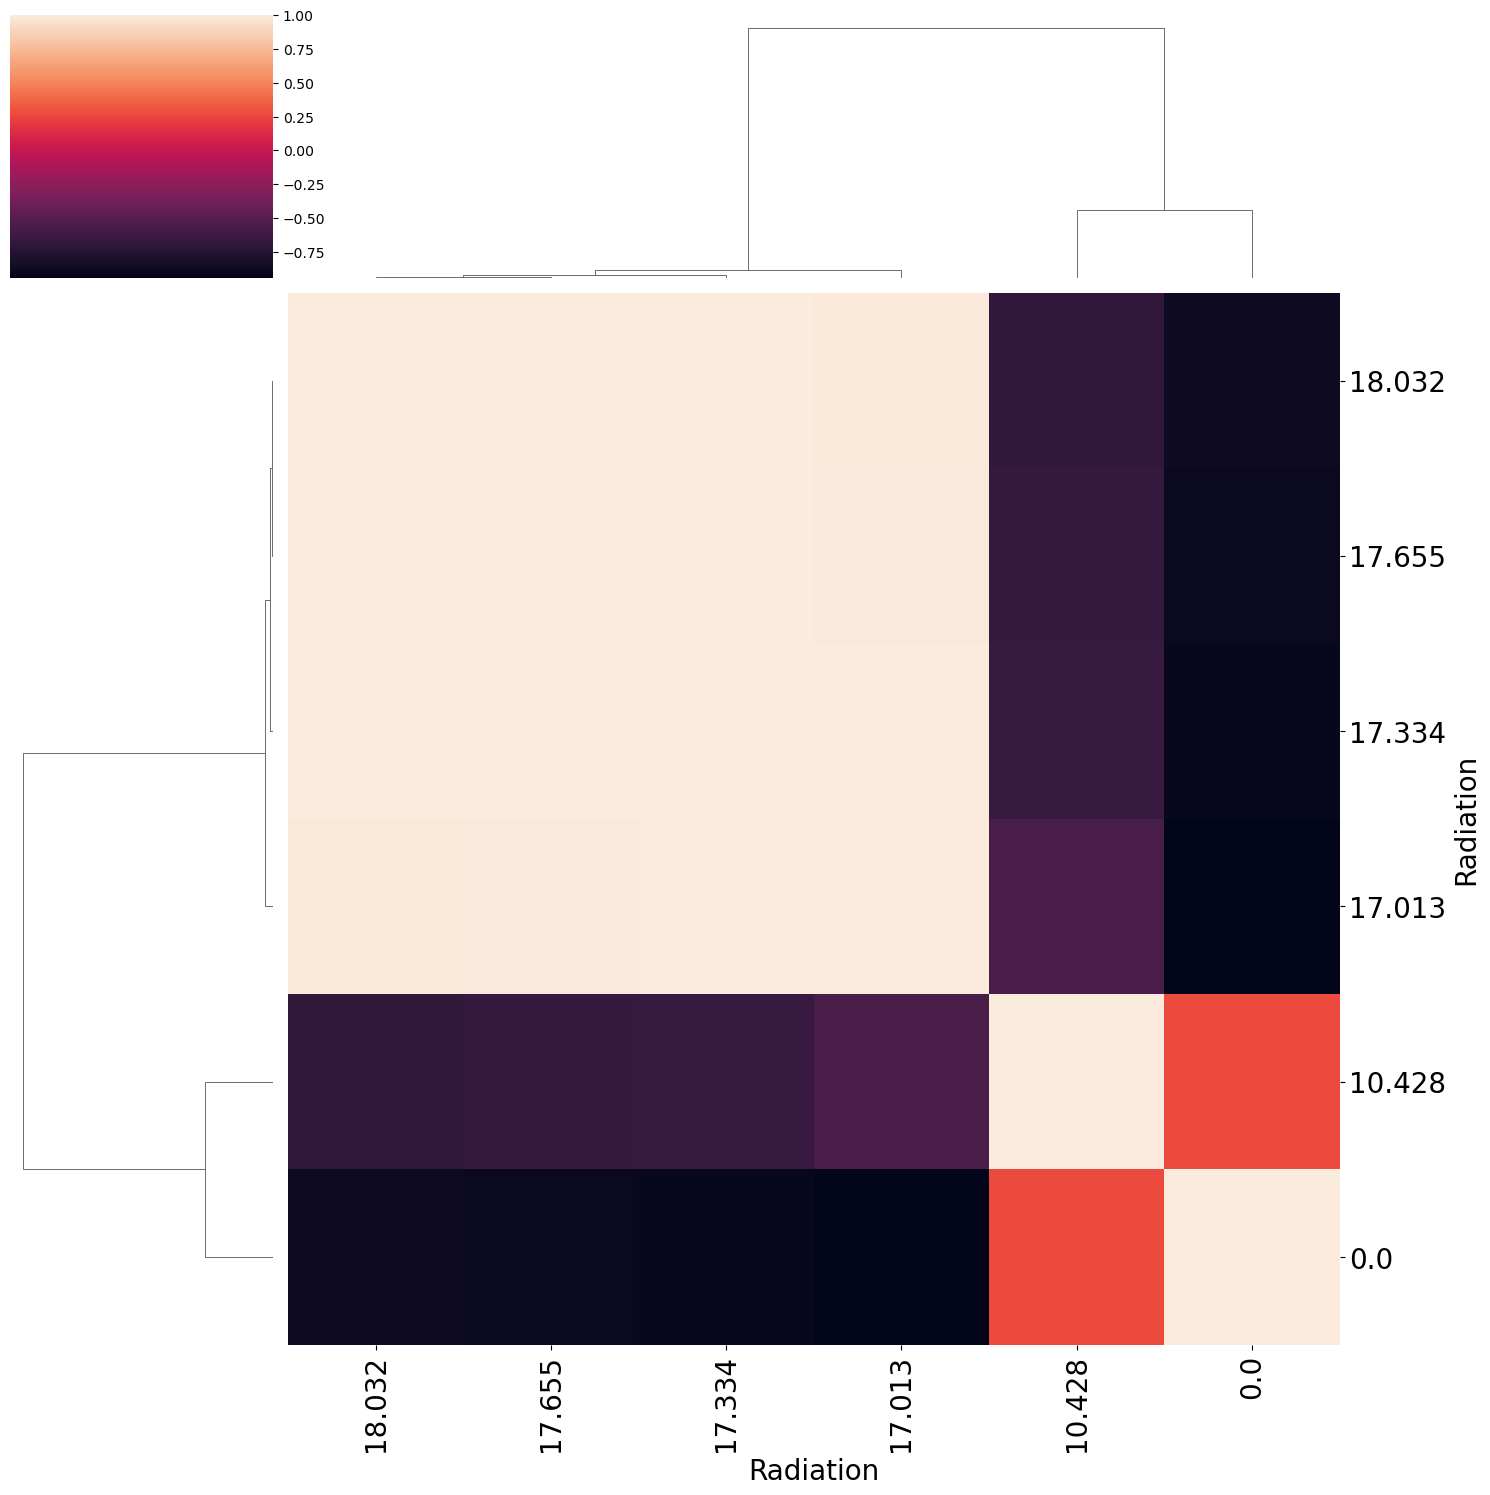

In [42]:
linkage = hc.linkage(df_agg.corr(), method='complete', optimal_ordering=True)
h = sns.clustermap(df_agg.corr(), row_linkage=linkage, col_linkage=linkage, yticklabels=1, xticklabels=1, figsize=(15, 15))
h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xticklabels(), rotation=90, fontsize=20)
h.ax_heatmap.set_ylabel("Radiation", fontsize=20)
h.ax_heatmap.set_xlabel("Radiation", fontsize=20)
plt.tight_layout()
plt.show()

In [61]:
sc.pp.pca(adata_emb)
sc.pp.neighbors(adata_emb, use_rep="X")
sc.tl.umap(adata_emb)

In [62]:
adata_emb.obs.leiden = adata_emb.obs.leiden.astype('category')
adata_emb.obs.radiation = adata_emb.obs.radiation.astype('float')

In [66]:
idx = []
for ti, tissue in enumerate(adata_emb.obs["spacflight"].cat.categories):
    cts = adata[adata.obs["spaceflight"].isin([tissue])].obs['absorbed_radiation_dose_float'].unique()
    
    idx.append(list(np.where((adata_emb.obs["spacflight"].isin([tissue])) & (adata_emb.obs["radiation"].isin(cts)))[0]))

adata_emb = adata_emb[np.concatenate(idx)]

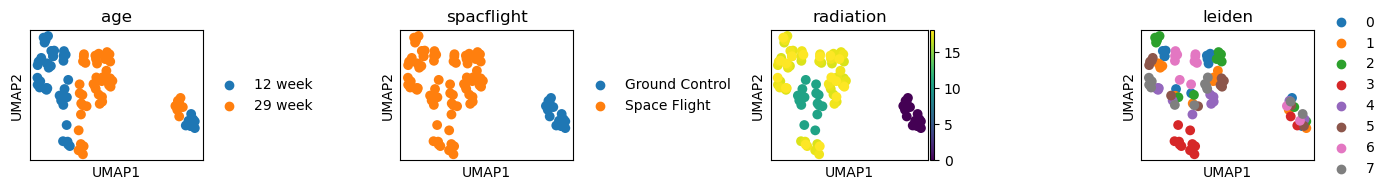

In [67]:
fig, axs = plt.subplots(1, 4, figsize=(14, 2))
for i, c in enumerate(["age", "spacflight", "radiation", 'leiden']):
    sc.pl.umap(
        adata_emb,
        size=200,
        color=[c],
        ax=axs[i], 
        show=False
    )
plt.tight_layout()
plt.show()

# We now perform counterfactuals on Ground Control cells to predict their gene expression under radiatio, whilst keeping the rest of the attributes fixed

In [44]:
idx_source = np.where(adata.obs["radiation"] == 0.000000)[0]

adata_ctl = adata[idx_source].copy()

In [45]:
model.to_device('cpu')

In [47]:
adata_preds = model.compute_prediction_adata(
    adata, adata_ctl, target_attributes=['radiation'], add_attributes=['age', 'spaceflight', 'leiden'], 
)

0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:06,  6.45s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:11,  5.49s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:12,  3.44s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:13,  2.63s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


5it [00:15,  2.33s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


6it [00:15,  2.65s/it]
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/biolord/_model.py:916: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['29 week', '29 week', '29 week', '29 week', '29 week', ..., '29 week', '29 week', '29 week', '29 week', '29 week']
Length: 44928
Categories (2, object): ['12 week', '29 week']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_preds.obs.iloc[start : start + adata_source.shape[0], -1] = adata_source.obs[attribute_]
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/sc_analysis/lib/python3.11/site-packages/biolord/_mo

In [48]:
adata_preds.write_h5ad("radiation_counterfactuals.h5ad")